# Microbiome Sonification Experiments

This notebook guides you through microbiome data visualisation and sonification in the R programming language. We will explore an open microbiome dataset using the mia package for microbiome data analysis, including:

- [Alpha diversity](#Alpha-diversity)
- [Beta diversity](#Beta-diversity)
- [Bacterial abundance](#Bacterial-abundance)
- [Sample composition](#Sample-composition)
- [Phylogeny](#Phylogeny)

In the past, R had a very nice package for data sonification called playitbyr, which was using the same syntax as the famous ggplot2 package designed for data visualisation. Unfortunately, playitbyr is no longer maintained, so we will have to use the lower-level sonify package. To see (or hear) what playitbyr was capable of, go to [this address](http://playitbyr.org/).

Fun fact: ggplot2 is what most R programmers use to make publication-ready figures!

## System setup

If you are running this notebook on Google Collab, you will need to run the code chunk below to install the necessary packages. It takes about 15 minutes.

In [1]:
# Set to 1 to install packages
install <- 0

if( install == 1 ){
    # Install sonification packages
    install.packages(c("BiocManager", "sonify", "BrailleR"))
    # Install microbiome packages
    BiocManager::install(c("mia", "miaViz", "scater"))
    # Install text-to-speech synthesiser
    system("sudo apt-get -y install espeak-ng")
}

Once installation is complete, import the packages to get started.

In [2]:
# Import packages
suppressPackageStartupMessages({
    library(BrailleR)
    library(mia)
    library(miaViz)
    library(scater)
    library(sonify)
})

We will analyse the GlobalPatterns dataset, which includes 28 microbiome samples from either the environment or the human body. More information on this study is available at [this address](https://microbiome.github.io/mia/reference/GlobalPatterns.html).

In [3]:
# Load dataset
data("GlobalPatterns", package = "mia")
tse <- GlobalPatterns

# Make sample types compatible with espeak
tse$SampleType <- gsub("\\)", "", gsub(" \\(", "_", tse$SampleType))

The original dataset contains an abundance table with 19216 microbial features as rows and 26 samples as columns. That is pretty big, so we will agglomerate it to a higher taxonomic rank. This basically means summing up counts from closely-related bugs to end up with fewer microbial features, or rows.

In [4]:
# Transform counts to relative abundance
tse <- transformAssay(tse, method = "relabundance")

# Agglomerate by Phylum
tse <- agglomerateByPrevalence(
    tse,
    prevalence = 50/100,
    detection = 1/100,
    rank = "Phylum"
)

# Print experiment
tse

class: TreeSummarizedExperiment 
dim: 35 26 
metadata(2): agglomerated_by_rank agglomerated_by_rank
assays(2): counts relabundance
rownames(35): Acidobacteria Actinobacteria ... WS3 Other
rowData names(7): Kingdom Phylum ... Genus Species
colnames(26): CL3 CC1 ... Even2 Even3
colData names(7): X.SampleID Primer ... SampleType Description
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
rowLinks: a LinkDataFrame (35 rows)
rowTree: 1 phylo tree(s) (35 leaves)
colLinks: NULL
colTree: NULL

## Alpha diversity

Alpha diversity reflects the microbial diversity *within one sample*. How diverse is the gut microbiome? And how about the soil microbiome? We can use an alpha diversity metric (like Faith's phylogenetic diversity) to quantify and compare the microbial diversity within those samples.

In [7]:
# Subset feces and soi  samples
tse_sub <- tse[ , tse$SampleType %in% c("Feces", "Soil")]

# Estimate alpha diversity
tse_sub <- addAlpha(tse_sub, index = "faith_diversity")

Warning message:
“The following values are already present in `colData` and will be overwritten: 'faith_diversity'. Consider using the 'name' argument to specify alternative names.”


Once alpha diversity is estimated, we can visualise it with a boxplot. Compared to human fecal samples, soil samples turn out to be much more diverse!

This chart has title 'Alpha Diversity Boxplot'.
It has x-axis 'SampleType' with labels Feces and Soil.
It has y-axis 'faith_diversity' with labels 6.0, 6.5, 7.0 and 7.5.
There is a legend indicating colour is used to show colour_by, with 2 levels:
Feces shown as light blue colour and 
Soil shown as brilliant orange colour.
It has 2 layers.
Layer 1 is a violin graph that VI cannot process.
Layer 1 has fill set to purplish white.
Layer 1 has colour set to purplish gray.
Layer 1 has alpha set to 0.2.
Layer 2 is a set of 7 big solid circle points of which about 100% can be seen.
The points are at:
(0.82, 6.16) colour light blue which maps to colour_by = Feces, 
(1.2, 6.43) colour light blue which maps to colour_by = Feces, 
(0.78, 6.77) colour light blue which maps to colour_by = Feces, 
(1, 5.72) colour light blue which maps to colour_by = Feces, 
(2.17, 7.89) colour brilliant orange which maps to colour_by = Soil, 
(1.82, 7.76) colour brilliant orange which maps to colour_by = Soil and 


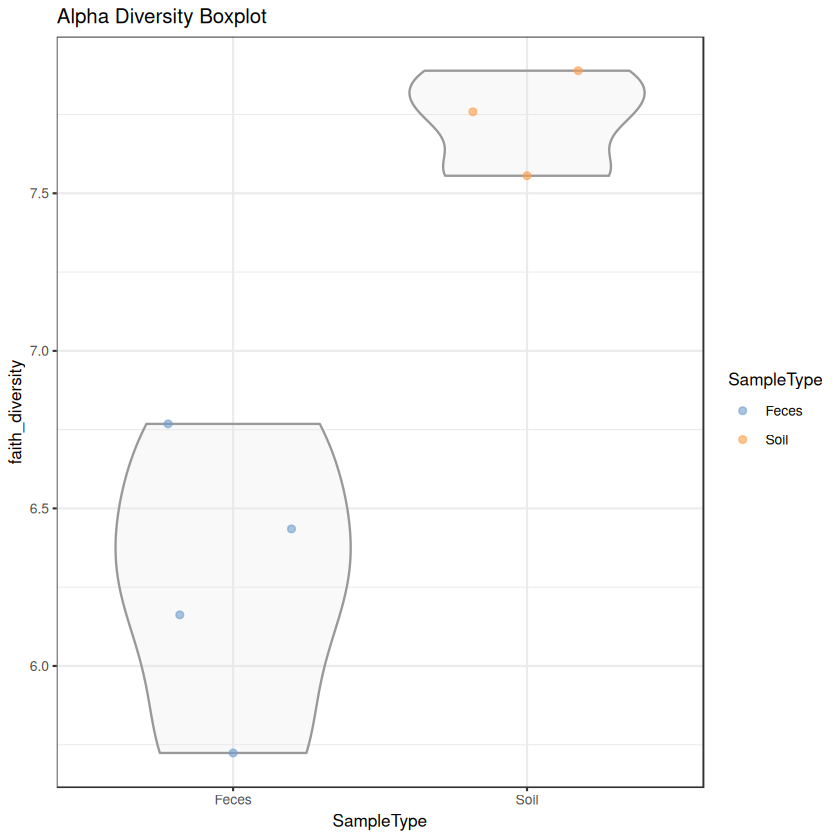

In [8]:
# Visualise alpha diversity
p <- plotColData(
    tse_sub,
    y = "faith_diversity",
    x = "SampleType",
    colour_by = "SampleType"
)

p + ggtitle("Alpha Diversity Boxplot")

How to sonify the boxplot above? First, we define a utility function below to convert vectors of numeric values to a proper frequency scale for sonification.

In [9]:
# Define function to convert numeric vector to frequencies
val2freq <- function(val) {

    norm_val <- (val - min(val)) / (max(val) - min(val))
    freq <- 440 + norm_val * (880 - 440)

    return(freq)
}

# Convert faith diversity to frequency
tse_sub$faith_frequency <- val2freq(tse_sub$faith_diversity)

The idea to sonify the alpha diversity boxplot is to play the value for each sample at a time, preceeded by the an audio with the name of the sample group.

In [10]:
# Split samples by origin
tse_list <- splitOn(tse_sub, group = "SampleType")

for( i in seq_along(tse_list) ){

    # Retrieve experiment from list
    exp <- tse_list[[i]]
    # Set frequency limits
    faith_lims <- c(min(exp$faith_frequency), max(exp$faith_frequency))

    # Speak sample name
    system2("espeak-ng", args = names(tse_list)[i])

    # Sonify alpha diversity
    sonify(
        y = exp$faith_diversity,
        waveform = "square",
        interpolation = "constant",
        flim = faith_lims,
        duration = 0.5 * ncol(exp),
        player = "mplayer",
    )
}

## Beta diversity

Beta diversity reflects the diversity *between samples*, that is, how similar or distant the microbial communities from different samples are. How similar is the skin microbiome to the tongue microbiome? Hopefully very different!

Typically, beta diversity is visualised with an ordination plot, which resembles a Principal Component Analysis (PCA) plot, if you are familiar with that. The idea is to reduce the features of a sample, that is, the number of rows, to only two dimensions that are the axes of an ordination plot.

This chart has title 'Ordination plot of beta diversity'.
It has x-axis 'MDS 1' with labels 0.0, 0.1 and 0.2.
It has y-axis 'MDS 2' with labels -0.05, 0.00, 0.05 and 0.10.
There is a legend indicating colour is used to show colour_by, with 9 levels:
Feces shown as light blue colour, 
Freshwater shown as brilliant orange colour, 
Freshwater_creek shown as brilliant yellowish green colour, 
Mock shown as strong reddish orange colour, 
Ocean shown as light violet colour, 
Sediment_estuary shown as light reddish brown colour, 
Skin shown as strong purplish pink colour, 
Soil shown as light gray colour and 
Tongue shown as light greenish yellow colour.
The chart is a set of 26 big solid circle points of which about 92% can be seen.
It has alpha set to 0.6.
It has fill set to dark grayish olive green.
It has shape set to big solid circle.

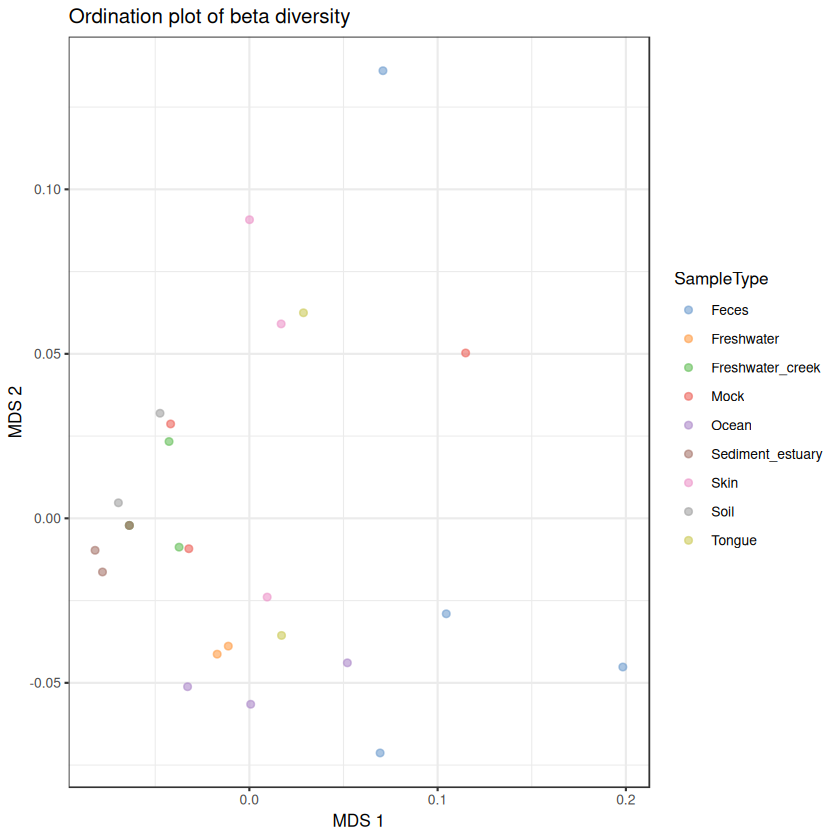

In [11]:
# Compute beta diversity
tse <- runMDS(
    tse,
    FUN = getDissimilarity,
    assay.type = "relabundance",
    method = "unifrac",
    tree = rowTree(tse),
    ntop = nrow(tse)
)

# Visualise beta diversity
p <- plotReducedDim(tse, "MDS", colour_by = "SampleType")
p + ggtitle("Ordination plot of beta diversity")

To sonify an ordination plot, we can play a sound reflecting the y-axis value for every sample or point in the plot, with a background noise to reflect the concentration of samples along the x-axis. Ideally, we would keep only bursts instead of continuous sounds, but that is the limit of sonify.

In [12]:
# Retrieve beta diversity
dim_red <- reducedDim(tse, "MDS")

# Sonify beta diversity
sonify(
    x = dim_red[ , 1], y = dim_red[ , 2],
    waveform = "square", interpolation = "constant",
    pulse_len = 0.1, pulse_amp = 0.5,
    duration = 10, player = "mplayer",
)

## Bacterial abundance

Bacterial abundance means the total counts of bacterial DNA inside a sample, which can be further divided into abundance of different bacterial taxa, such as species, families, phyla, etc. For this purpose, we use a compositional barplot, where each bar shows the total bacterial abundance for one sample.

This chart has title 'Composition Barplot'.
It has x-axis 'Samples' with labels Feces, Freshwater, Freshwater_creek, Mock, Ocean, Sediment_estuary, Skin, Soil and Tongue.
It has y-axis 'Abundance' with labels 0e+00, 1e+06, 2e+06, 3e+06, 4e+06 and 5e+06.
There is a legend indicating fill is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue fill, 
Bacteroidetes shown as brilliant orange fill, 
Cyanobacteria shown as brilliant yellowish green fill, 
Firmicutes shown as strong reddish orange fill, 
Other shown as light violet fill and 
Proteobacteria shown as light reddish brown fill.
There is a legend indicating colour is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue colour, 
Bacteroidetes shown as brilliant orange colour, 
Cyanobacteria shown as brilliant yellowish green colour, 
Firmicutes shown as strong reddish orange colour, 
Other shown as light violet colour and 
Proteobacteria shown as light reddish brown colour.
The chart is a b

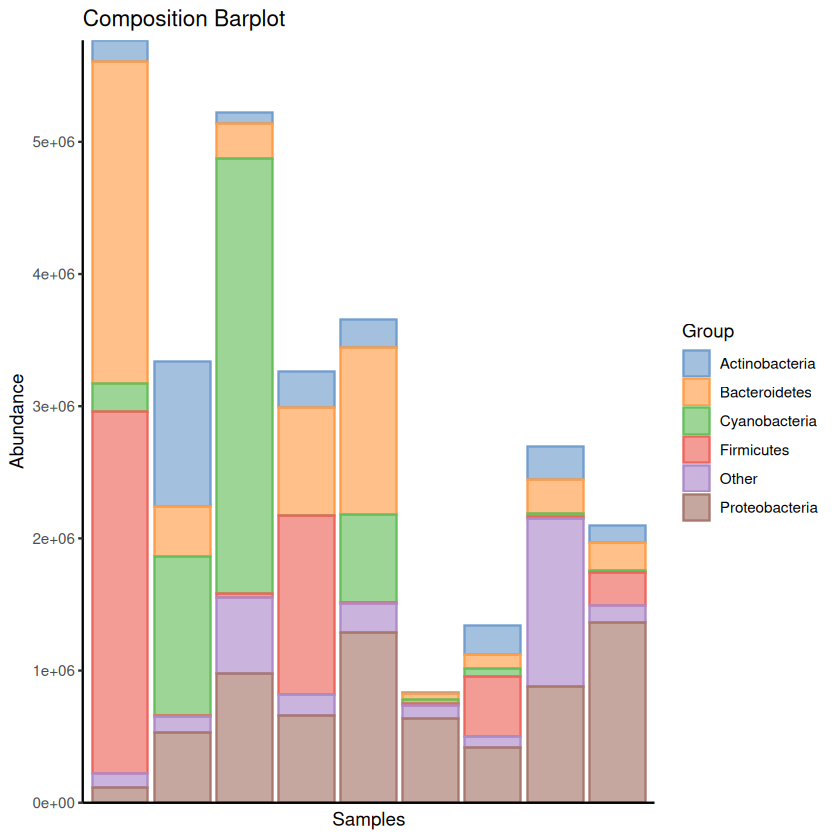

In [13]:
# Agglomerate by sample type
tse <- agglomerateByVariable(
    tse,
    by = 2L,
    group = "SampleType"
)

# Find top taxa
top_taxa <- getTop(tse)
rowData(tse)$Group <- ifelse(rowData(tse)$Phylum %in% top_taxa,
                             rowData(tse)$Phylum, "Other")

# Visualise composition barplot
p <- plotAbundance(tse, group = "Group")
p + ggtitle("Composition Barplot")

The compositional barplot can be sonified by playing the bacterial abundance for each sample as a sound. The higher the abundance, the higher the frequency of the sound played.

In [ ]:
# Compute total abundance per sample
col_sums <- colSums(assay(tse, "counts"))
# Convert abundance to frequency
col_sums <- val2freq(col_sums)

for( i in seq_along(col_sums) ){

    # Retrieve total abundance
    col_sum <- col_sums[i]
    # Speak sample type
    system2("espeak-ng", args = names(col_sum))

    # Sonify total abundance
    sonify(
        y = col_sum,
        waveform = "square",
        interpolation = "constant",
        flim = c(col_sum, col_sum),
        duration = 0.5,
        player = "mplayer",
    )
}

## Sample composition

What if we want to sonify the composition of a single sample, that is, the abundance of different types of bacteria? Something that could reflect the content of the plot below.

This chart has title 'Microbial composition in soil'.
It has x-axis 'Samples' with labels Soil.
It has y-axis 'Abundance' with labels 0, 500000, 1000000, 1500000, 2000000 and 2500000.
There is a legend indicating fill is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue fill, 
Bacteroidetes shown as brilliant orange fill, 
Cyanobacteria shown as brilliant yellowish green fill, 
Firmicutes shown as strong reddish orange fill, 
Other shown as light violet fill and 
Proteobacteria shown as light reddish brown fill.
There is a legend indicating colour is used to show colour_by, with 6 levels:
Actinobacteria shown as light blue colour, 
Bacteroidetes shown as brilliant orange colour, 
Cyanobacteria shown as brilliant yellowish green colour, 
Firmicutes shown as strong reddish orange colour, 
Other shown as light violet colour and 
Proteobacteria shown as light reddish brown colour.
The chart is a bar chart with 1 vertical bars.
Bar 1 is centered at 1, and length is f

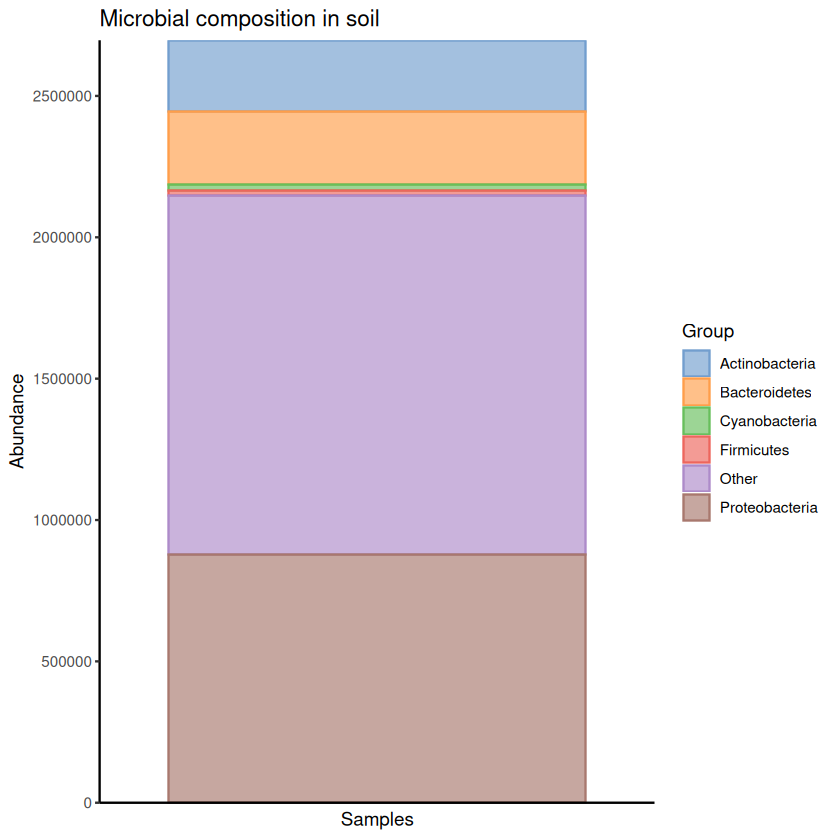

In [ ]:
# Subset soil samples
tse_sub <- tse[ , tse$SampleType == "Soil"]

# Agglomerate features by top 5 phyla
tse_sub <- agglomerateByVariable(
    tse_sub,
    by = 1L,
    group = "Group"
)

# Visualise microbial composition in soil
p <- plotAbundance(tse_sub, group = "Group")
p + ggtitle("Microbial composition in soil")

As before, we can map the abundance of each type of bacteria to frequency of sound. But this time we focus to only one sample and go through its composition one bacterium at a time.

In [ ]:
soil_sums <- val2freq(as.vector(assay(tse_sub, "counts")))
names(soil_sums) <- rownames(tse_sub)

for( i in seq_along(soil_sums) ){

    # Retrieve feature abundance
    soil_sum <- soil_sums[i]
    # Speak feature name
    system2("espeak-ng", args = names(soil_sum))

    # Sonify feature abundance
    sonify(
        y = soil_sum,
        waveform = "square",
        interpolation = "constant",
        flim = c(soil_sum, soil_sum),
        duration = 0.5,
        player = "mplayer",
    )
}

## Phylogeny: the ultimate challenge

Phylogenetic trees lie at the core of microbiome data science. They represent the taxonomic similarity between microorganisms in a community. R doesn't really have a way to sonify or even textualise this plot, but someone figure out how it can be done and in principle it could be implemented on top of sonify or playitbyr (if this was still around).

The approach to sonify phylogenetic trees is described in [this article](https://hal.science/hal-01893569). Its basic idea is to go through the tree from the root to the tips and produce a sound every time a branch splits into two new branches. By combining multiple chords, closely-related bugs will sound alike, wheareas distant bugs will sound very different.

To explore a phylogenetic tree, we use the smaller Tengeler2020 dataset, a study on the associations between gut microbiome and Attention Deficit Hyperactivity Disorder (ADHD). For this, 27 mice were humanised with fecal microbial samples from one of three ADHD and three control subjects. More information on this study is available at [this address](https://microbiome.github.io/outreach/tengeler2020_presentation.html).

In [ ]:
# Load dataset
data("Tengeler2020", package = "mia")
tse <- Tengeler2020

# Print tse
tse

class: TreeSummarizedExperiment 
dim: 151 27 
metadata(0):
assays(1): counts
rownames(151): Bacteroides Bacteroides_1 ... Parabacteroides_8
  Unidentified_Lachnospiraceae_14
rowData names(6): Kingdom Phylum ... Family Genus
colnames(27): A110 A12 ... A35 A38
colData names(4): patient_status cohort patient_status_vs_cohort
  sample_name
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):
rowLinks: a LinkDataFrame (151 rows)
rowTree: 1 phylo tree(s) (151 leaves)
colLinks: NULL
colTree: NULL

Phylogenetic trees can be visualised with the function below. You can play with the layout to get different shapes and organisations.

This chart has title 'Phylogenetic Tree'.
It has x-axis '' with labels 0.0, 0.5 and 1.0.
It has y-axis '' with labels 50, 100 and 150.
There is a legend indicating colour is used to show edge_colour_by, with 5 levels:
Bacteroidetes shown as light blue colour, 
Cyanobacteria shown as brilliant orange colour, 
Firmicutes shown as brilliant yellowish green colour, 
Proteobacteria shown as strong reddish orange colour and 
Verrucomicrobia shown as light violet colour.
It has 4 layers.
Layer 1 is a segment graph that VI cannot process.
Layer 2 is a segment graph that VI cannot process.
Layer 3 is a segment graph that VI cannot process.
Layer 3 has alpha set to 1.
Layer 4 is a segment graph that VI cannot process.
Layer 4 has alpha set to 1.

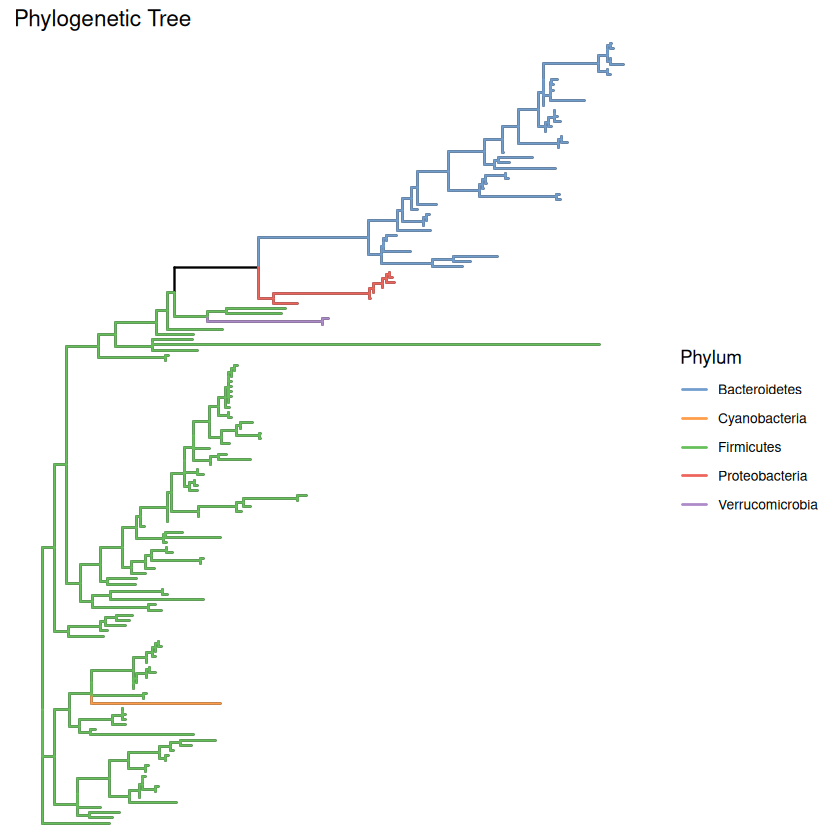

In [ ]:
# Visualise phylogenetic tree
p <- plotRowTree(
    tse,
    layout = "rectangular",
    edge_colour_by = "Phylum"
)

p + ggtitle("Phylogenetic Tree")

In [ ]:
# sonify() How???

## Additional resources

- [Accessible Data Science for the Blind Using R](https://jooyoungseo.com/post/ds4blind/)
- [Microbiome turned DJ: Biota Beats](https://biotabeats.org/visualization.html)
- [Orchestrating Microbiome Analysis with Bioconductor](https://microbiome.github.io/OMA/)
- [BiliBili Tutorial on Phylogeny Sonification](https://www.bilibili.com/video/BV1ydxPeGEok/?buvid=YF4A73FDB2A6D554425BAF43A0A82915397A&from_spmid=search.search-result.0.0&is_story_h5=false&mid=HbSPY7IrFHktyJUZi%2BLvQQ%3D%3D&plat_id=116&share_from=ugc&share_medium=iphone_i&share_plat=ios&share_session_id=9C95499E-B69B-44E4-995D-9EA3392F704A&share_source=COPY&share_tag=s_i&spmid=united.player-video-detail.0.0&timestamp=1727491843&unique_k=PIyokrA&up_id=1619965160)